In [1]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device: CPU 224 cores


In [2]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [3]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR  = '\033[32m'
YELLOW = '\033[33m'
RESET  = '\033[0m'

In [4]:
## -- Load Data --
PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/sylvesterdalmeida/myheart-disease-dataset/'
# ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [5]:
# ## -- Load data from Colab --
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/--colab--notebooks--/Ps6e1 | Student Test Score/student_test_dataset/'
# submit = pd.read_csv(PATH+'sample_submission.csv')
# train = pd.read_csv(PATH+'train.csv').drop('id', axis=1)
# test = pd.read_csv(PATH+'test.csv').drop('id', axis=1)
# orig = pd.read_csv(PATH+'Exam_Score_Prediction.csv').drop('student_id', axis=1)

# TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# BASE = NUMS + CATS

# for (name, df) in dict(Train=train, Test=test, Original=orig).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")
# print(f"Total base features: {len(BASE)}")

In [6]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: float64(1), 

In [7]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

,Age,BP,Cholesterol,Max HR,ST depression,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Train,42,66,150,93,66,2,4,2,3,2,3,4,3
Original,41,47,144,90,39,2,4,2,3,2,3,4,3
Test,43,64,145,92,64,2,4,2,3,2,3,4,3


## FEATURE ENGINEERING

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin ## ===== Target/Category Mean ENCODERS =====

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed


class CategoryMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols=None):
        self.cat_cols = cat_cols
        self.mappings_ = {}
    def fit(self, X, y):
        X = X.copy()
        if self.cat_cols is None:
            self.cat_cols = X.select_dtypes(include=['category']).columns.tolist()
        self.mappings_ = {}
        for col in self.cat_cols:
            df_temp = pd.DataFrame({col: X[col], 'y': y})
            group_means = df_temp.groupby(col, dropna=False)['y'].mean()
            sorted_categories = group_means.sort_values().index
            self.mappings_[col] = {cat: i for i, cat in enumerate(sorted_categories)}
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col, mapping in self.mappings_.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)
        return X

In [9]:
def orig_TE_data_propagate(
    orig: pd.DataFrame,
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    features: list = None,
    aggs: list = None,
    fill_nan: bool = False,
):

    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"
            
            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET].mean().reset_index(name=new_col))
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET].median().reset_index(name=new_col))
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size().reset_index(name=new_col)) #.astype('int32')
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET].nunique().reset_index(name=new_col)) #.astype('int32')
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET].std().reset_index(name=new_col))
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET].skew().reset_index(name=new_col))
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET].max().reset_index(name=new_col))
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET].min().reset_index(name=new_col))
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    global_mean   = orig[TARGET].mean()
    global_median = orig[TARGET].median()
    
    def fill_conditionally(df):
        for c in ORIG:
            if '_mean' in c or '_max' in c or '_min' in c:
                df[c] = df[c].fillna(global_mean)
            elif '_median' in c:
                df[c] = df[c].fillna(global_median)
            else:
                df[c] = df[c].fillna(0)
        return df

    if fill_nan:
        X_train_df = fill_conditionally(X_train_df)
        X_val_df   = fill_conditionally(X_val_df)
        X_test_df  = fill_conditionally(X_test_df)

    return X_train_df, X_val_df, X_test_df, ORIG

In [10]:
# train, test, _, NEW_COLS = orig_TE_data_propagate(
#     orig,
#     train,
#     test,
#     train.iloc[:500],
#     features = BASE,
#     ## --- (count, mean, count, std, nunique, median, max, min)
#     aggs = ['count'],
#     # fill_nan=True,
# )

# print(NEW_COLS)

In [11]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


# ML TRAINING

In [12]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):
    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")
    start = time()
    
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n##### FOLD {idx+1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target], train_df.loc[val_idx, target]
        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        ## -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count', 'std'], # mean, count, std, nunique, median, max, min
            # fill_nan=True,
        )

        cme_features = NUMS 
        cme_cols = []

        print(f"CategoryMeanEncoding: {len(cme_features)} | ", end='')
        for c in cme_features:
            n = f"CME_{c}"
            CME = CategoryMeanTransformer(cat_cols=[c])
            X_train[n] = CME.fit_transform(X_train[[c]], y_train).fillna(-1)
            X_val[n]   = CME.transform(X_val[[c]]).fillna(-1)
            X_test[n]  = CME.transform(X_test[[c]]).fillna(-1)
            cme_cols.append(n)

        ## -- TE Opt1. -> Using CUSTOM --
        TE = TargetEncoder(cme_cols, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
        X_train = TE.fit_transform(X_train, y_train)
        X_val   = TE.transform(X_val)
        X_test  = TE.transform(X_test)
        
        combined = pd.concat([X_train, X_val, X_test])
        for c in cats:
            combined[c] = combined[c].astype('category')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f"Train shape: {X_train.shape} #####")

        if 'HIST' in model_name:
            model = HistGradientBoostingClassifier(**params)
            model.fit(X_train, y_train)
        elif 'XT' in model_name:
            model = ExtraTreesClassifier(**params)
            model.fit(X_train, y_train)

        ## -- Predict on validation and test sets --
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1].ravel()
        test_preds += model.predict_proba(X_test)[:, 1].ravel()

        ## -- Calculate and print fold score --
        fold_auc = roc_auc_score(y_val.to_numpy(), oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f" {YELLOW}FOLD {idx+1} AUC: {fold_auc:.5f}{RESET}")

        ## -- Clean up memory -- X_val
        del X_train, y_train, y_val, X_test
        gc.collect()

    ## -- Average the test predictions
    test_preds /= kf.n_splits

    ## -- Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    
    for i, score in enumerate(fold_scores):
        print(f"FOLD {i+1} AUC: {score:.6f}")
    
    ## -- Calculate and print the final out-of-fold AUC
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')
    
    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
        'val_data': X_val,
    }

print('===== ⚙️ Training function ready ⚙️ =====')

===== ⚙️ Training function ready ⚙️ =====


In [13]:
all_model_predictions = {}

SEED_2 = 777
SEED_3 = 1234
SEED_4 = 24611
SEED_5 = 0

N_SPLITS = 15
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

kf

StratifiedKFold(n_splits=15, random_state=42, shuffle=True)

# HIST

In [14]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """
# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'HIST_trial'

# ITERATIONS = 10_000
# LR = 0.01
# LOOP = [0.0]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")

#     PARAMS = {
#         'max_iter': ITERATIONS,
#         'learning_rate': LR,
#         'max_features': 0.1,
#         'n_iter_no_change': 10,
#         'l2_regularization': value,
#         # 'scoring': 'loss',
#         'tol': 1e-5,
#         'verbose': 0,
#         'random_state': SEED,
#     }
    
#     n = M_NAME + str(LR).split('.')[1] + str(value)
    
#    all_model_predictions[n] = Trainer_CV(**{
#        'model_name': n,
#        'params': PARAMS,
#        'train_df': train,
#        'test_df': test,
#        'features': FEATURES,
#        'target': TARGET,
#        'kf': kf,
#        'cats': CATS
#    }
    
#     COMPILER.append(all_model_predictions)
    
# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [15]:
# ## -- Get Scores --
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(18, 6))
# sns.lineplot(all_model_scores, marker='o')
# # pd.Series(all_model_scores).plot(marker='o')
# plt.title('HISTOGRAM PARAMETER SCORES', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score+7e-7, score, ha='center', va='center_baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [16]:
version_name = 'HISTv1'

ITERATIONS = 5000
LR = 0.02
MAX_FEAT = 0.1

PARAMS = {
    'max_iter': ITERATIONS,
    'learning_rate': LR,
    'max_features': MAX_FEAT,
    # 'n_iter_no_change': 10,
    # 'l2_regularization': 0.0,
    # 'scoring': 'loss',
    'tol': 1e-5,
    'verbose': 0,
    'random_state': SEED,
}

M_NAME = f"{version_name}_"
n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for HISTv1_42 ====================



##### FOLD 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 1 AUC: 0.95545

##### FOLD 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 2 AUC: 0.95548

##### FOLD 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 3 AUC: 0.95542

##### FOLD 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 4 AUC: 0.95525

##### FOLD 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 5 AUC: 0.95370

##### FOLD 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 6 AUC: 0.95438

##### FOLD 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 7 AUC: 0.95550

##### FOLD 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 8 AUC: 0.95548

##### FOLD 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 9 AUC: 0.95488

##### FOLD 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 10 AUC: 0.95445

##### FOLD 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 11 AUC: 0.95424

##### FOLD 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 12 AUC: 0.95582

##### FOLD 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 13 AUC: 0.95628

##### FOLD 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 14 AUC: 0.95511

##### FOLD 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 15 AUC: 0.95531

Cross-Validation Results for HISTv1_42
FOLD 1 AUC: 0.955450
FOLD 2 AUC: 0.955482
FOLD 3 AUC: 0.955417
FOLD 4 AUC: 0.955246
FOLD 5 AUC: 0.953695
FOLD 6 AUC: 0.954380
FOLD 7 AUC: 0.955498
FOLD 8 AUC: 0.955480
FOLD 9 AUC: 0.954883
FOLD 10 AUC: 0.954455
FOLD 11 AUC: 0.954245
FOLD 12 AUC: 0.955817
FOLD 13 AUC: 0.956276
FOLD 14 AUC: 0.955106
FOLD 15 AUC: 0.955311
-------------------------------------------------|
Overall AUC: 0.95511
Average AUC: 0.955116 ± 0.000649
-------------------------------------------------|
4.46 mins


==================== Starting Cross-Validation for HISTv1_777 ====================

##### FOLD 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 1 AUC: 0.95554

##### FOLD 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 2 AUC: 0.95552

##### FOLD 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 3 AUC: 0.95547

##### FOLD 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 4 AUC: 0.95525

##### FOLD 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 5 AUC: 0.95377

##### FOLD 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 6 AUC: 0.95440

##### FOLD 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 7 AUC: 0.95545

##### FOLD 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 8 AUC: 0.95540

##### FOLD 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 9 AUC: 0.95493

##### FOLD 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 10 AUC: 0.95443

##### FOLD 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 11 AUC: 0.95433

##### FOLD 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 12 AUC: 0.95579

##### FOLD 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 13 AUC: 0.95640

##### FOLD 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 14 AUC: 0.95506

##### FOLD 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 15 AUC: 0.95532

Cross-Validation Results for HISTv1_777
FOLD 1 AUC: 0.955544
FOLD 2 AUC: 0.955518
FOLD 3 AUC: 0.955465
FOLD 4 AUC: 0.955250
FOLD 5 AUC: 0.953771
FOLD 6 AUC: 0.954402
FOLD 7 AUC: 0.955448
FOLD 8 AUC: 0.955403
FOLD 9 AUC: 0.954933
FOLD 10 AUC: 0.954434
FOLD 11 AUC: 0.954326
FOLD 12 AUC: 0.955794
FOLD 13 AUC: 0.956397
FOLD 14 AUC: 0.955061
FOLD 15 AUC: 0.955322
-------------------------------------------------|
Overall AUC: 0.955131
Average AUC: 0.955138 ± 0.000646
-------------------------------------------------|
4.62 mins


==================== Starting Cross-Validation for HISTv1_1234 ====================

##### FOLD 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 1 AUC: 0.95544

##### FOLD 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 2 AUC: 0.95556

##### FOLD 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 3 AUC: 0.95536

##### FOLD 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 4 AUC: 0.95526

##### FOLD 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 5 AUC: 0.95370

##### FOLD 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 6 AUC: 0.95434

##### FOLD 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 7 AUC: 0.95551

##### FOLD 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 8 AUC: 0.95543

##### FOLD 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 9 AUC: 0.95490

##### FOLD 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 10 AUC: 0.95442

##### FOLD 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 11 AUC: 0.95429

##### FOLD 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 12 AUC: 0.95576

##### FOLD 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 13 AUC: 0.95629

##### FOLD 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 14 AUC: 0.95513

##### FOLD 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 15 AUC: 0.95538

Cross-Validation Results for HISTv1_1234
FOLD 1 AUC: 0.955445
FOLD 2 AUC: 0.955556
FOLD 3 AUC: 0.955358
FOLD 4 AUC: 0.955261
FOLD 5 AUC: 0.953699
FOLD 6 AUC: 0.954341
FOLD 7 AUC: 0.955511
FOLD 8 AUC: 0.955431
FOLD 9 AUC: 0.954902
FOLD 10 AUC: 0.954423
FOLD 11 AUC: 0.954295
FOLD 12 AUC: 0.955755
FOLD 13 AUC: 0.956288
FOLD 14 AUC: 0.955126
FOLD 15 AUC: 0.955385
-------------------------------------------------|
Overall AUC: 0.955113
Average AUC: 0.955118 ± 0.000648
-------------------------------------------------|
4.71 mins


==================== Starting Cross-Validation for HISTv1_24611 ====================

##### FOLD 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 1 AUC: 0.95549

##### FOLD 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 2 AUC: 0.95557

##### FOLD 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 3 AUC: 0.95536

##### FOLD 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 4 AUC: 0.95526

##### FOLD 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 5 AUC: 0.95375

##### FOLD 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 6 AUC: 0.95435

##### FOLD 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 7 AUC: 0.95547

##### FOLD 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 8 AUC: 0.95547

##### FOLD 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 9 AUC: 0.95489

##### FOLD 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 10 AUC: 0.95444

##### FOLD 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 11 AUC: 0.95428

##### FOLD 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 12 AUC: 0.95578

##### FOLD 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 13 AUC: 0.95622

##### FOLD 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 14 AUC: 0.95507

##### FOLD 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 15 AUC: 0.95545

Cross-Validation Results for HISTv1_24611
FOLD 1 AUC: 0.955493
FOLD 2 AUC: 0.955568
FOLD 3 AUC: 0.955359
FOLD 4 AUC: 0.955262
FOLD 5 AUC: 0.953746
FOLD 6 AUC: 0.954345
FOLD 7 AUC: 0.955471
FOLD 8 AUC: 0.955471
FOLD 9 AUC: 0.954887
FOLD 10 AUC: 0.954435
FOLD 11 AUC: 0.954277
FOLD 12 AUC: 0.955777
FOLD 13 AUC: 0.956217
FOLD 14 AUC: 0.955068
FOLD 15 AUC: 0.955451
-------------------------------------------------|
Overall AUC: 0.955115
Average AUC: 0.955122 ± 0.000639
-------------------------------------------------|
4.47 mins


==================== Starting Cross-Validation for HISTv1_0 ====================

##### FOLD 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 1 AUC: 0.95549

##### FOLD 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 2 AUC: 0.95549

##### FOLD 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 3 AUC: 0.95537

##### FOLD 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 4 AUC: 0.95527

##### FOLD 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 5 AUC: 0.95380

##### FOLD 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 6 AUC: 0.95440

##### FOLD 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 7 AUC: 0.95549

##### FOLD 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 8 AUC: 0.95548

##### FOLD 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 9 AUC: 0.95491

##### FOLD 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 10 AUC: 0.95442

##### FOLD 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 11 AUC: 0.95434

##### FOLD 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 12 AUC: 0.95580

##### FOLD 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 13 AUC: 0.95631

##### FOLD 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 14 AUC: 0.95506

##### FOLD 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | 

Train shape: (588000, 44) #####


 FOLD 15 AUC: 0.95539

Cross-Validation Results for HISTv1_0
FOLD 1 AUC: 0.955487
FOLD 2 AUC: 0.955493
FOLD 3 AUC: 0.955365
FOLD 4 AUC: 0.955272
FOLD 5 AUC: 0.953804
FOLD 6 AUC: 0.954395
FOLD 7 AUC: 0.955491
FOLD 8 AUC: 0.955478
FOLD 9 AUC: 0.954907
FOLD 10 AUC: 0.954417
FOLD 11 AUC: 0.954343
FOLD 12 AUC: 0.955797
FOLD 13 AUC: 0.956315
FOLD 14 AUC: 0.955058
FOLD 15 AUC: 0.955388
-------------------------------------------------|
Overall AUC: 0.955128
Average AUC: 0.955134 ± 0.000632
-------------------------------------------------|
4.50 mins



In [17]:
# ==================================================
# Cross-Validation Results for HISTv1_42
# ==================================================
# FOLD 1 AUC: 0.955917
# FOLD 2 AUC: 0.954804
# FOLD 3 AUC: 0.955625
# FOLD 4 AUC: 0.955245
# FOLD 5 AUC: 0.956069
# ------------------------------------------------- |
# Overall AUC: 0.955529
# Average AUC: 0.955532 ± 0.000460
# ------------------------------------------------- |
# 1.18 mins

# EXTRA TREES

In [18]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """
# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'XT_trial_'

# ITERATIONS = 5_000
# LOOP = [0.3, 0.5, 0.8]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")

#     PARAMS = {
#         'n_estimators': ITERATIONS,
#         # 'max_depth': None,
#         # 'max_features': value,
#         'min_samples_leaf': 20,
#         'verbose': 1,
#         'n_jobs': os.cpu_count(),
#         'random_state': SEED,
#     }
    
#     n = M_NAME + str(value)
    
#     all_model_predictions[n] = Trainer_CV(**{
#         'model_name': n,
#         'params': PARAMS,
#         'train_df': train,
#         'test_df': test,
#         'features': FEATURES,
#         'target': TARGET,
#         'kf': kf,
#         'cats': CATS
#     }
    
#     COMPILER.append(all_model_predictions)
    
# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [19]:
# ## -- Get Scores --
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(18, 6))
# sns.lineplot(all_model_scores, marker='o')
# # pd.Series(all_model_scores).plot(marker='o')
# plt.title('HISTOGRAM PARAMETER SCORES', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score+7e-7, score, ha='center', va='center_baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [20]:
# version_name = 'XTv1'

# PARAMS = {
#     'n_estimators': 2000,
#     # 'max_depth': None,
#     # 'max_features': 0.4,
#     'min_samples_leaf': 10,
#     'verbose': 0,
#     'n_jobs': os.cpu_count(),
#     'random_state': SEED,
# }

# M_NAME = f"{version_name_2}_"
# n = M_NAME + str(SEED)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS,
# )

# ## -- UPDATE SEED_2 --
# PARAMS['random_state'] = SEED_2
# n = M_NAME + str(SEED_2)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS,
# )

# ## -- UPDATE SEED_3 --
# PARAMS['random_state'] = SEED_3
# n = M_NAME + str(SEED_3)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS,
# )

# ## -- UPDATE SEED_4 --
# PARAMS['random_state'] = SEED_4
# n = M_NAME + str(SEED_4)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS,
# )

# ## -- UPDATE SEED_5 --
# PARAMS['random_state'] = SEED_5
# n = M_NAME + str(SEED_5)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS,
# )

# # v1_Xtrees_5_SEEDS

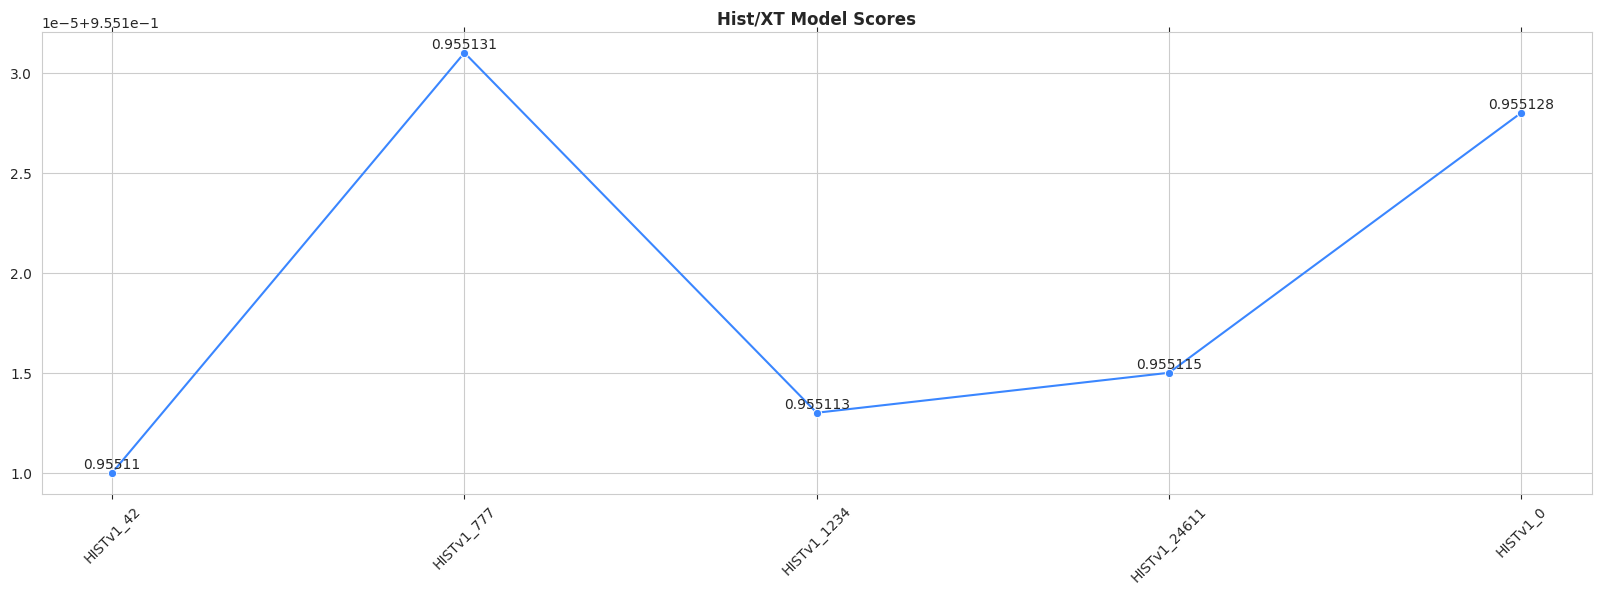

In [21]:
## -- Get models scores --
all_model_scores = {} 

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            all_model_scores[k] = y

plt.figure(figsize=(20, 6))
sns.lineplot(all_model_scores, marker='o')
# pd.Series(all_model_scores).plot(marker='o')
plt.title('Hist/XT Model Scores', fontweight='semibold')
plt.tick_params('x', rotation=45, reset=True)

for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+5e-7, score, ha='center', va='center_baseline')

plt.show()

In [22]:
## -- Get oof predictions --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

,HISTv1_42_95511,HISTv1_777_955131,HISTv1_1234_955113,HISTv1_24611_955115,HISTv1_0_955128
0,0.994976,0.994344,0.994003,0.994722,0.995328
1,0.016167,0.014449,0.014626,0.015796,0.013863
2,0.011949,0.013121,0.013255,0.013429,0.014348
3,0.037641,0.037250,0.037126,0.035947,0.037639
4,0.995119,0.995101,0.994597,0.995304,0.995407


In [23]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

,HISTv1_42_95511,HISTv1_777_955131,HISTv1_1234_955113,HISTv1_24611_955115,HISTv1_0_955128
0,0.936644,0.935860,0.933535,0.935237,0.940913
1,0.007670,0.007581,0.007486,0.007626,0.007736
2,0.984998,0.985700,0.985252,0.985296,0.984786
3,0.006582,0.006261,0.006284,0.006337,0.006332
4,0.212630,0.221105,0.214672,0.205647,0.208430


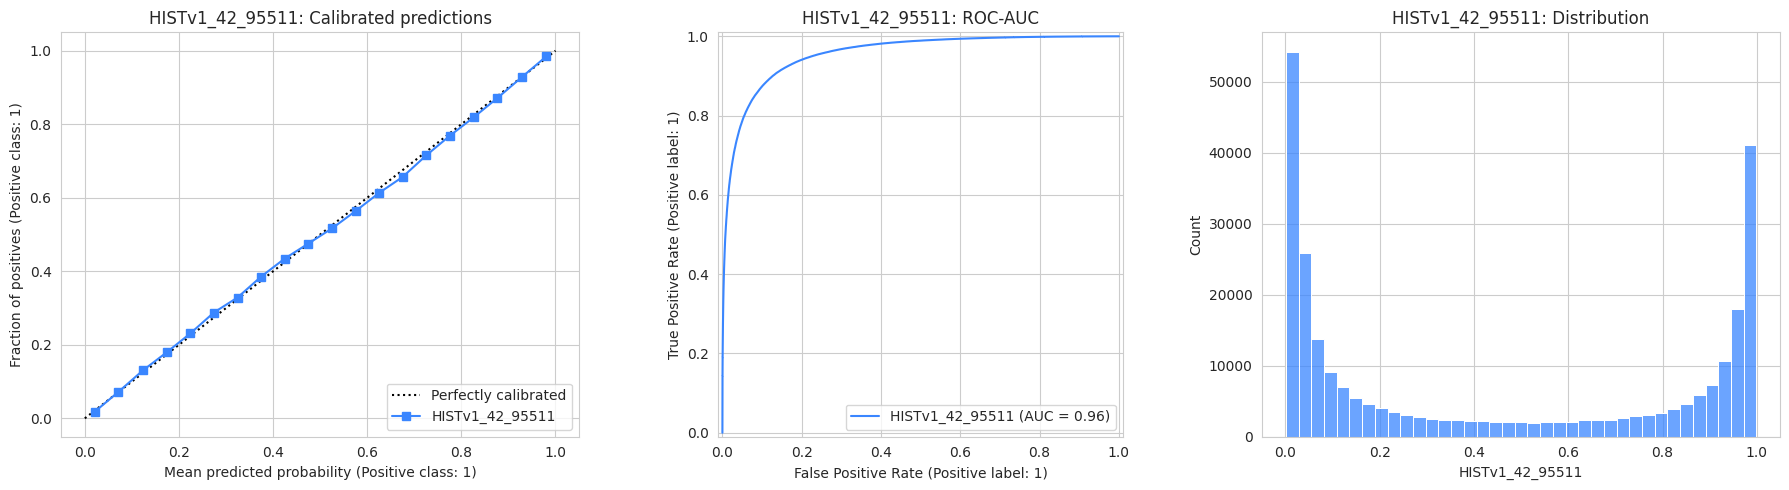

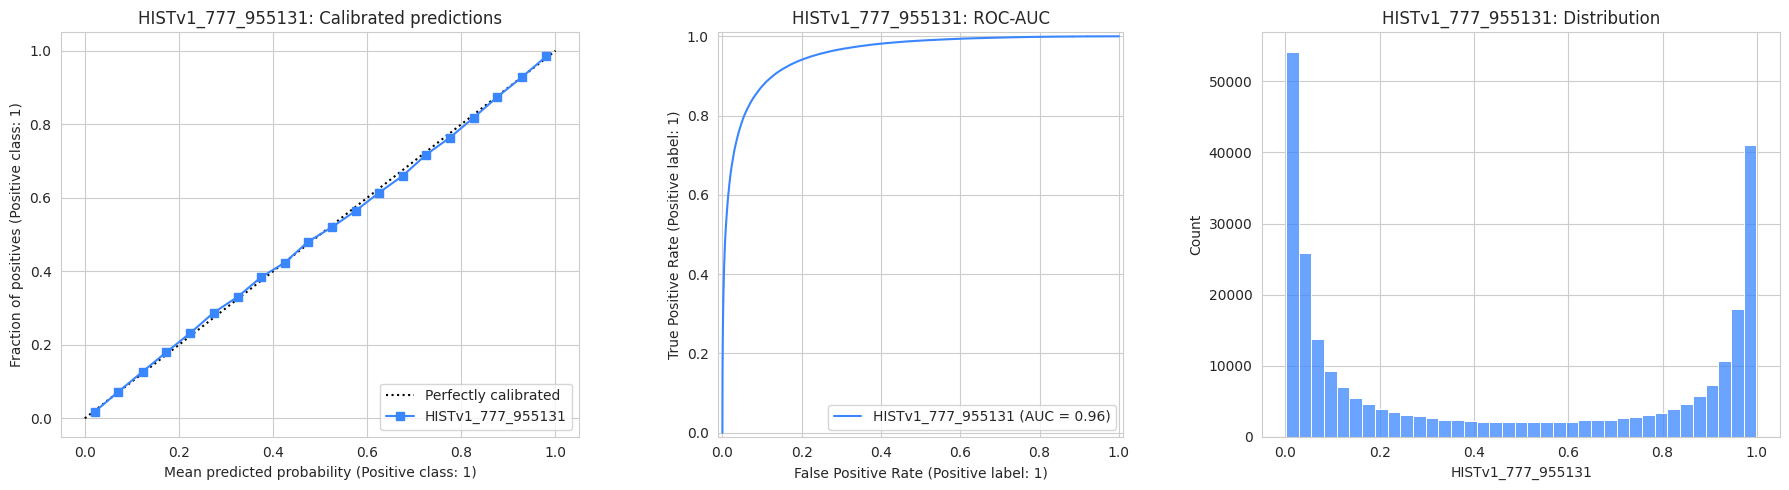

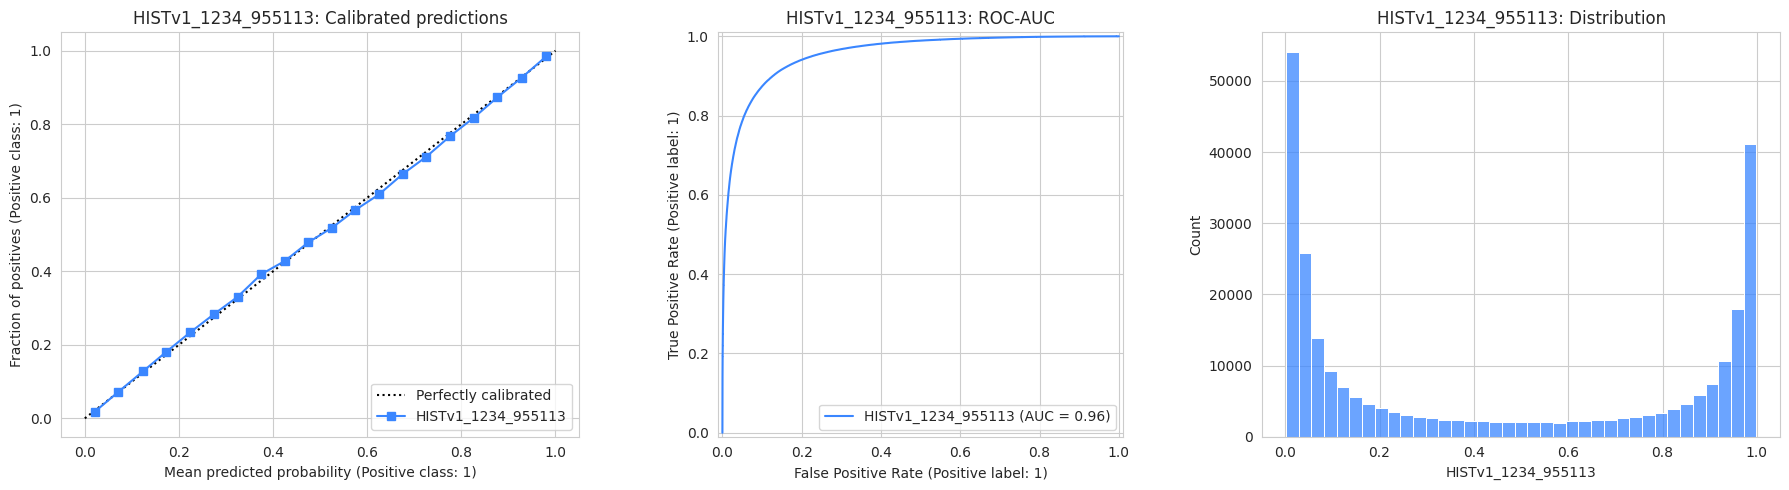

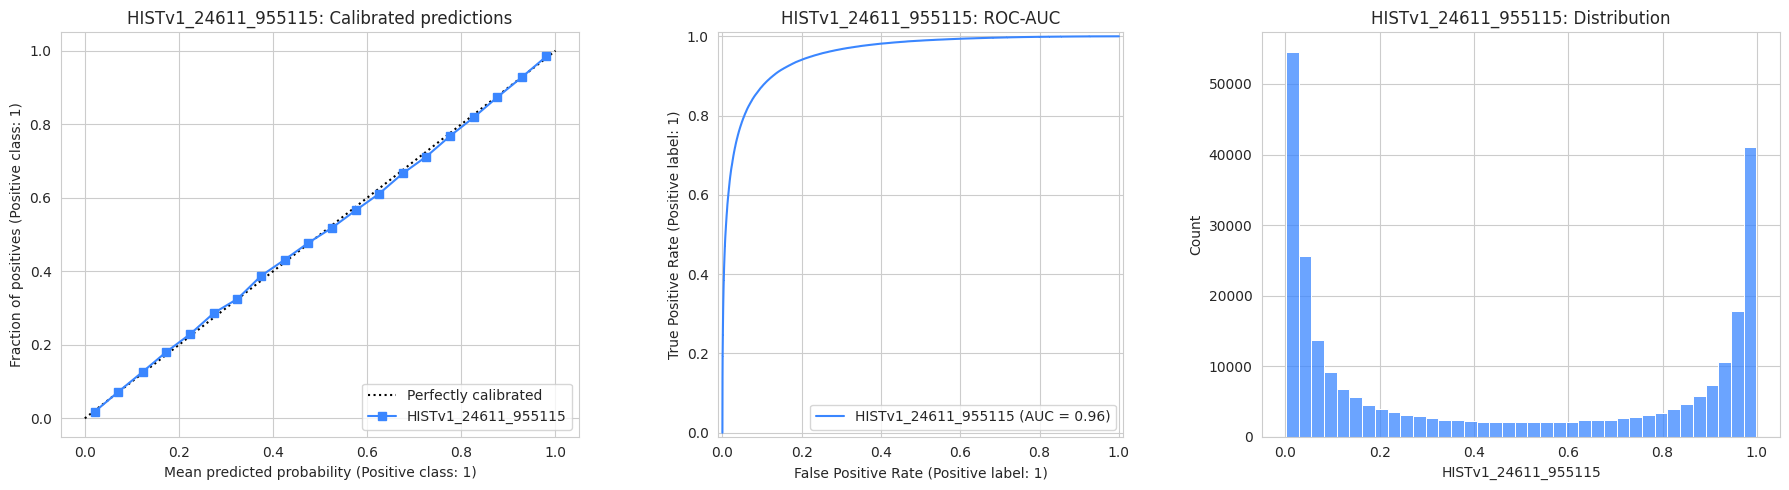

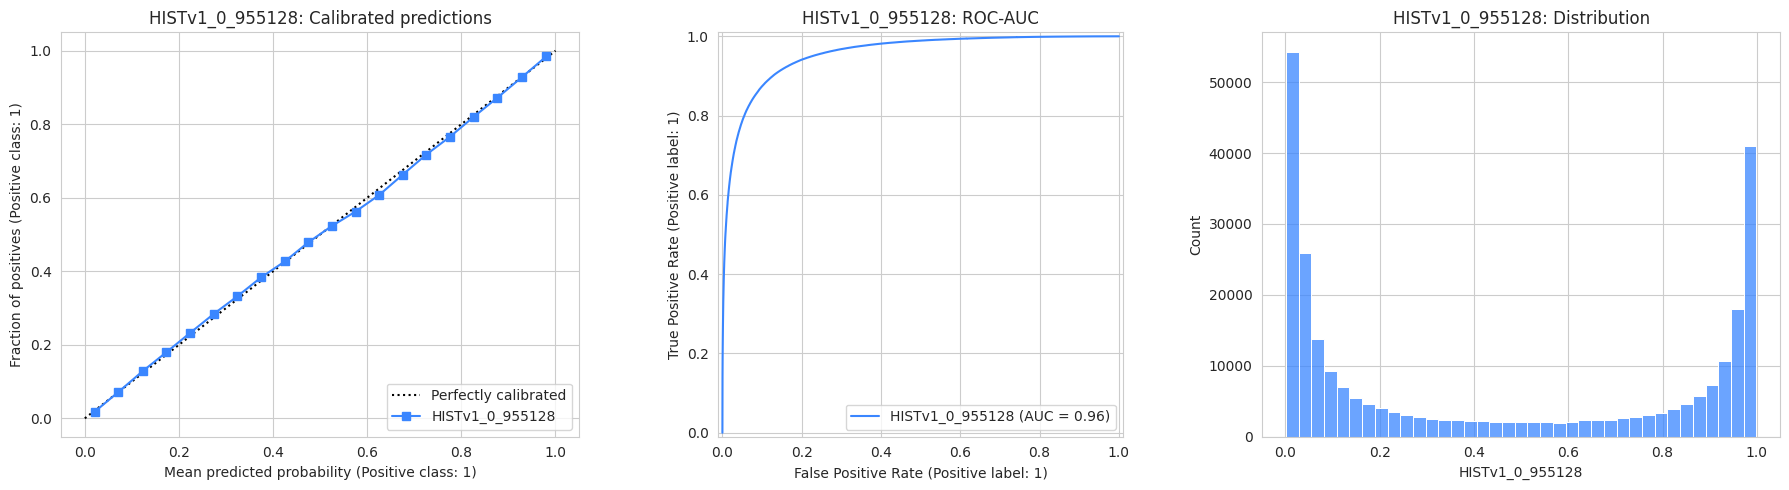

In [24]:
## -- PLOT PREDICTIONS --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")
    
    ## -- ROC curve
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")
    
    plt.tight_layout()
    plt.show()
    print()

In [25]:
%pip install -U shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


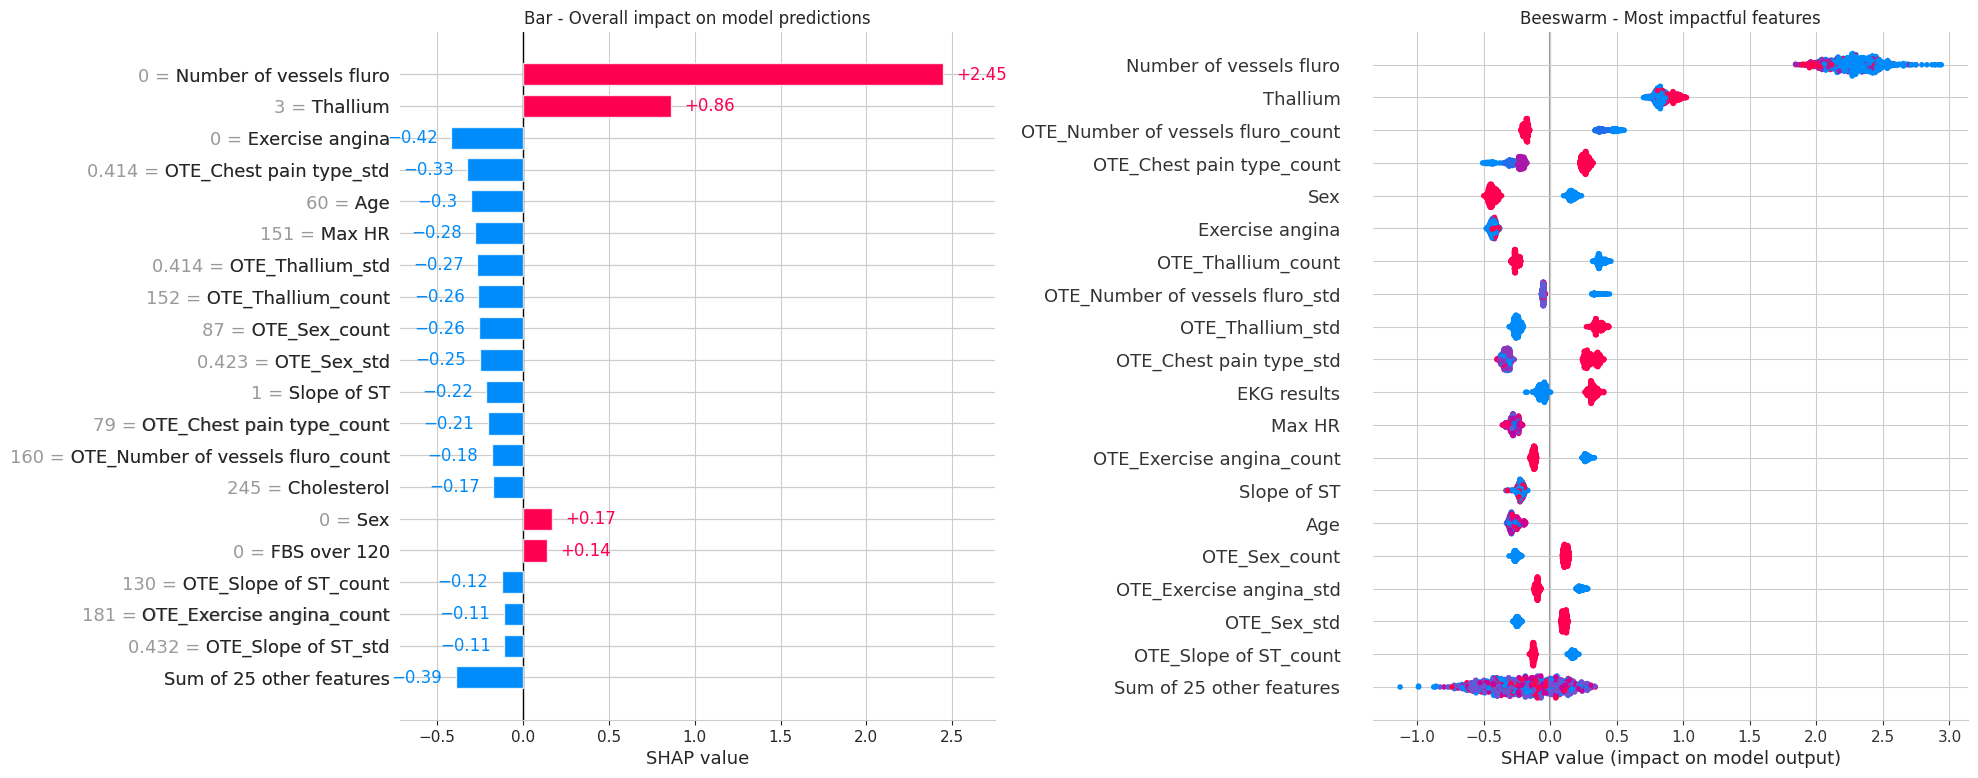

In [26]:
## -- PLOT SHAP VALUES --
model1 = all_model_predictions[list(all_model_predictions.keys())[0]]
# model2 = all_model_predictions[list(all_model_predictions.keys())[-1]]

MAX = 20
for i, m in enumerate([model1]): # , model2
    ## -- Shap Explainer --
    explainer = shap.TreeExplainer(m['model'])
    explanation = explainer(m['val_data'].iloc[:1000])

    ## -- Bar plot --
    plt.subplot(121)
    shap.plots.bar(
        explanation[0],
        max_display=MAX,
        show=False
    )
    plt.title('Bar - Overall impact on model predictions')

    ## -- Beeswarm plot --
    plt.subplot(122)
    shap.plots.beeswarm(
        explanation,
        max_display=MAX,
        order=explanation.abs.max(0),
        color_bar=False,
        plot_size=(20, 8),
        show=False,
    )

    plt.title('Beeswarm - Most impactful features')
    # plt.suptitle(f"{k}", fontweight='bold', fontsize=15, color='r')
    
    plt.tight_layout(pad=1.5)
    plt.show()
    print()